## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                           
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0749 - val_loss: 0.2873
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0648 - val_loss: 0.2466
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0556 - val_loss: 0.2096
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0472 - val_loss: 0.1767
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0398 - val_loss: 0.1475
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 0.0333 - val_loss: 0.1220
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0276 - val_loss: 0.0998
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0226 - val_loss: 0.0807
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184 - val_loss: 0.0643
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0506
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0392
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - 

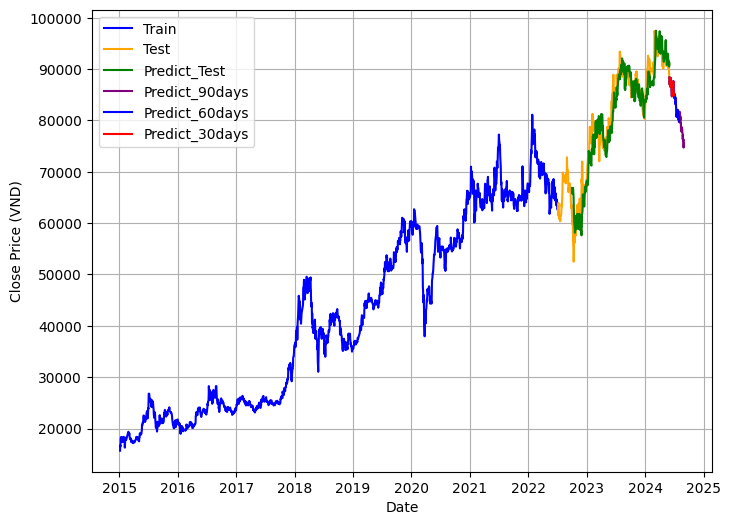

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  88327.492188
2024-06-02  88009.265625
2024-06-03  86954.757812
2024-06-04  87691.343750
2024-06-05  86936.625000
...                  ...
2024-08-25  76249.093750
2024-08-26  76000.437500
2024-08-27  76329.445312
2024-08-28  74707.335938
2024-08-29  75646.109375

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3066.5800743975037
MAPE: 2.9947413883847394 %
MAE: 2325.808478860294


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                      
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - val_loss: 9.0313e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - val_loss: 9.0936e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1019e-04 - val_loss: 0.0019
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3952e-04 - val_loss: 0.0018
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 8.4316e-04 - val_loss: 0.0013
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 8.0350e-04 - val_loss: 0.0013
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9415e-04 - val_loss: 0.0011
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8584e-04 - val_loss: 7.8081e-04
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2077e-04 - val_loss: 7.1742e-04
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 6.8535e-04 - val_loss: 6.7176e-04
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 6.4025e-04 - val_loss: 6.5151e-04
Epoch 1

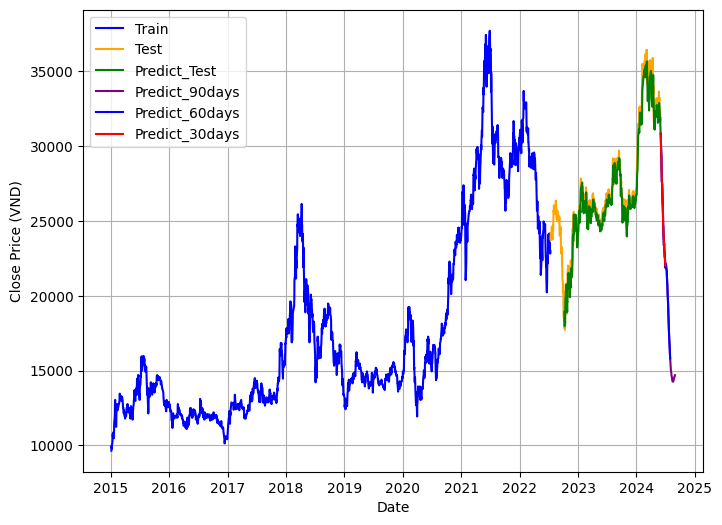

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  30845.613281
2024-06-02  30507.220703
2024-06-03  29902.816406
2024-06-04  29549.636719
2024-06-05  29274.964844
...                  ...
2024-08-25  14556.610352
2024-08-26  14564.880859
2024-08-27  14597.759766
2024-08-28  14640.945312
2024-08-29  14687.469727

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 692.8585516374189
MAPE: 1.969263710056465 %
MAE: 538.9469838783618


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))                                       
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0524 - val_loss: 0.0060
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 9.4988e-04 - val_loss: 9.7071e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5707e-04 - val_loss: 7.6177e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 6.4268e-04 - val_loss: 7.6669e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 5.3182e-04 - val_loss: 6.9171e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 4.7274e-04 - val_loss: 0.0011
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9609e-04 - val_loss: 0.0013
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8534e-04 - val_loss: 0.0015
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8542e-04 - val_loss: 0.0015
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 4.7995e-04 - val_loss: 0.0017
Epoch 12/200


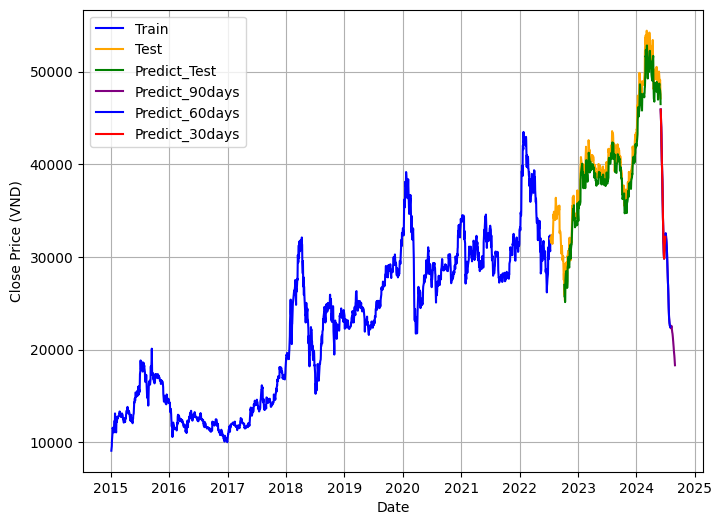

In [10]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  45899.597656
2024-06-02  45347.441406
2024-06-03  44537.847656
2024-06-04  43978.179688
2024-06-05  43151.929688
...                  ...
2024-08-25  19373.406250
2024-08-26  19138.501953
2024-08-27  18859.482422
2024-08-28  18585.380859
2024-08-29  18318.001953

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1332.3873286897388
MAPE: 2.7708447913405188 %
MAE: 1137.6685704462102
